In [117]:
# Partie 1 :
# Initialisation des paramètres financiers :
S = 50 # La valeur actuelle du sous-jacent
K = 50 # La valeur d'exercice (le strike)
r = 0.05 # Le taux d'intérêt sans risque
sigma = 0.25 # La volatilité
T = 3 # La maturité

In [118]:
# Partie 2 :
# Initialisation des paramètres numériques :
M = 100 # Le nombre de pas de temps
N = 400 # Le nombre de pas de sous-jacent
Szero = 0 # La valeur minimale du sous-jacent
Smax = 150 # La valeur maximale du sous-jacent
# Paramètres SOR :
omega = 1.2 # Le paramètre de relaxation
tol = 1e-3 # La tolérance pour la convergence

In [119]:
import numpy as np

In [120]:
# Partie 3.1 :
# Initialisation du maillage et de la matrice du système linéaire :
solution_mesh = np.zeros((N+1, M+1)) # La grille de la solution approchée
Smesh= np.linspace(0, Smax, M+1) # Maillage en S
Tmesh = np.linspace(T, 0, N+1) # Maillage en T

dt=T/N
dS=Smax/M
for i in range(0,M+1):
    # On soustrait au strike Smesh (un linespace qui va de 0 à Smax avec un pas de dS = 1,5)
    solution_mesh[0,i] = max(K-Smesh[i],0) # Condition initiale

for i in range(0,N+1):
    solution_mesh[i,0] = K*np.exp(-r*(T-Tmesh[i])) # Condition aux limites en S=0
    solution_mesh[i,M] = 0 # Condition aux limites en S=M

In [121]:
# Partie 3.2 :

# Définition des fonctions a, b et c :
def a(i):
    return 0.5*dt*(r*i-sigma**2*i**2)

def b(i):
    return 1+dt*(sigma**2*i**2+r)

def c(i):
    return -0.5*dt*(sigma**2*i**2+r*i)

# Construction de la matrice tri-diagonale :
Acoeffs = np.zeros(M+1)
Bcoeffs = np.zeros(M+1)
Ccoeffs = np.zeros(M+1)
for i in range(0,M+1):
    Acoeffs[i] = a(i)
    Bcoeffs[i] = b(i)
    Ccoeffs[i] = c(i)

tri_diag = np.diag(Acoeffs[2:M],-1) + np.diag(Bcoeffs[1:M]) + np.diag(Ccoeffs[1:M-1],1)
tri_inv = np.linalg.inv(tri_diag) # Inversion de la matrice tri-diagonale

In [122]:
# Partie 3.3 :
# Boucle en temps et schéma implicite + itération SOR :

for p in range(0,N):
    temp = np.zeros(M-1)
    RHS = np.zeros(M-1)

    temp[0] = a(0)*solution_mesh[p+1,0]
    temp[M-2] = c(M)*solution_mesh[p+1,M] # Terme à la frontière du domaine
    for i in range(1,M):
        RHS[i-1] = solution_mesh[p,i].T.conj() - temp[i-1]

    x = solution_mesh[p,1:M] # Vecteur x initial
    xold = 1000 * x # Initialisation xold pour commencer la boucle d'itération
    n = len(x)

    while np.linalg.norm(xold - x) > tol:
        xold = x
        for i in range(n):
            if i == 0:
                z = (RHS[i] - tri_diag[i,i+1] * x[i+1]) / tri_diag[i,i]
                x[i] = max(omega * z + (1 - omega) * xold[i], K - i * dS)
            elif i == n-1:
                z = (RHS[i] - tri_diag[i, i - 1] * x[i - 1]) / tri_diag[i, i]
                x[i] = max(omega * z + (1 - omega) * xold[i], K - i * dS)
            else:
                z = (RHS[i] - tri_diag[i,i-1] * x[i-1] - tri_diag[i,i+1] * x[i+1]) / tri_diag[i,i]
                x[i] = max(omega * z + (1 - omega) * xold[i], K - i * dS)
            # print("2: ")
            # print(x)
    solution_mesh[p+1,1:M] = x

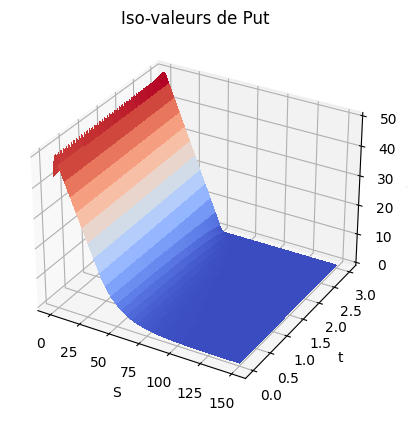

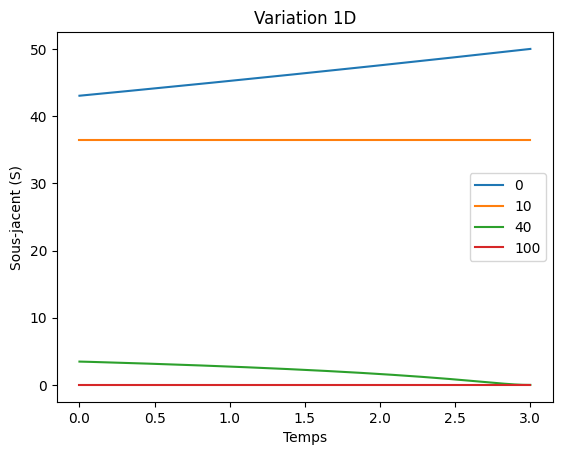

In [123]:
# Partie 4 :
import matplotlib.pyplot as plt
from matplotlib import cm

# Visualisation graphique des résultats :

# Iso-valeurs de la solution approchée :

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

X, Y = np.meshgrid(Smesh, Tmesh)
surf = ax.plot_surface(X, Y, solution_mesh, cmap=cm.coolwarm,
                          linewidth=0, antialiased=False)

ax.set_title("Iso-valeurs de Put")
ax.set_xlabel("S")
ax.set_ylabel("t")
ax.set_zlabel(" V(t,s)")
plt.show()

# Variation une dimensionnelle de la solution approchée :
fig, ax = plt.subplots()
ax.plot(Tmesh, solution_mesh[:,0], label="0")
ax.plot(Tmesh, solution_mesh[:,10], label="10")
ax.plot(Tmesh, solution_mesh[:,40], label="40")
ax.plot(Tmesh, solution_mesh[:,100], label="100")
ax.set_title("Variation 1D")
ax.set_xlabel("Temps")
ax.set_ylabel("Sous-jacent (S)")
ax.legend()
plt.show()